# CheXScan AlexNet Model

## Libraries

In [1]:
import numpy as np
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from PIL import Image

## Run this code if you're using Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

## Transform functions for data augmentation and normalization

You can further adjust these parameters if needed to achieve the desired balance between augmentation and maintaining image quality.

#### train_transform and test_transform

    Apply transformations to the input image for training data.

    Parameters:
        image (PIL.Image): Input image to be transformed.

    Returns:
        transformed_image (Tensor): Transformed image in tensor format.

In [3]:
train_transform = transforms.Compose([   
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [4]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Dataset Summary

In [5]:
data_dir = r"D:/Jupyter/chexscan-folder/chexscan/data"
train_data_dir = os.path.join(data_dir, 'train_data')
test_data_dir = os.path.join(data_dir, 'test_data')

In [6]:
def count_images_in_subdirectories(directory):
    subdirectories = os.listdir(directory)
    counts = {}
    for subdir in subdirectories:
        subdir_path = os.path.join(directory, subdir)
        count = sum(len(files) for _, _, files in os.walk(subdir_path))
        counts[subdir] = count
    return counts

In [7]:
train_counts = count_images_in_subdirectories(train_data_dir)
test_counts = count_images_in_subdirectories(test_data_dir)

print("Number of images in each subdirectory of training data:")
for subdir, count in train_counts.items():
    print(f"{subdir}: {count}")

print("\nNumber of images in each subdirectory of testing data:")
for subdir, count in test_counts.items():
    print(f"{subdir}: {count}")

Number of images in each subdirectory of training data:
Normal: 800
Pneumonia: 800
Tuberculosis: 800

Number of images in each subdirectory of testing data:
Normal: 200
Pneumonia: 200
Tuberculosis: 200


## Define datasets (Online)

In [8]:
data_dir = '/content/drive/My Drive/THESIS/Datasets/Mary/'
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train_data'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test_data'), transform=test_transform)

## Define datasets (Local)

In [9]:
data_dir = r"D:/Jupyter/chexscan-folder/chexscan/data"
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train_data'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test_data'), transform=test_transform)

## Define data loaders

In [10]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

## Visualizes training data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

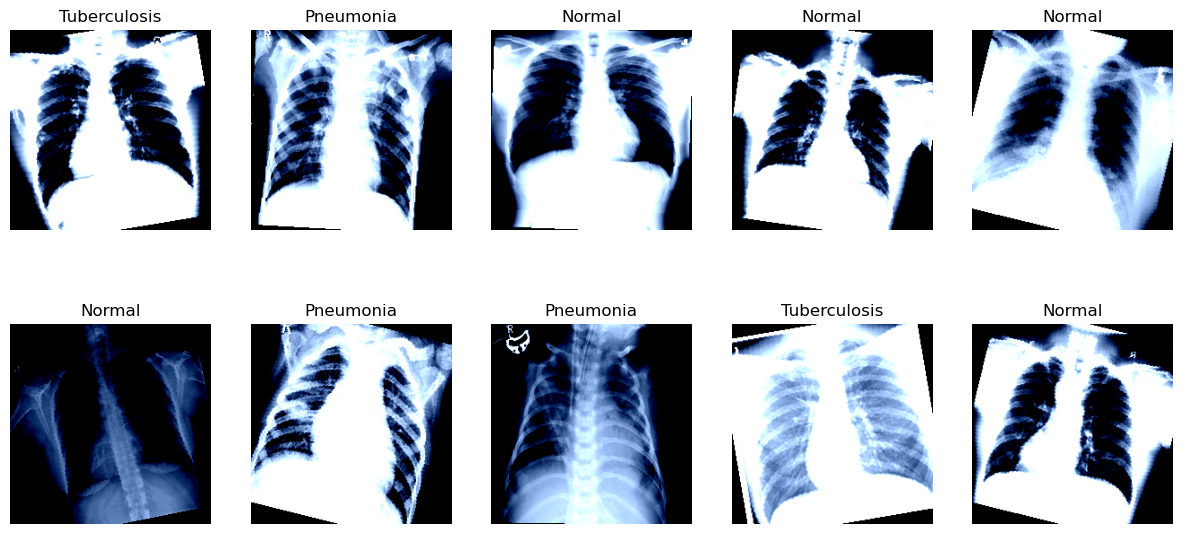

In [11]:
def visualize_training_data(loader):
    
    """
    Visualizes a batch of training images along with their corresponding labels.

    Parameters:
        loader (DataLoader): DataLoader containing the training dataset.

    Returns:
        None
    """
    
    classes = loader.dataset.classes
    class_names = {i: classes[i] for i in range(len(classes))}
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(figsize=(15, 7), ncols=5, nrows=2)
    for i, ax in enumerate(axes.flat):
        image = images[i].permute(1, 2, 0)
        ax.imshow(image)
        ax.set_title(class_names[labels[i].item()])
        ax.axis('off')
    plt.show()

visualize_training_data(train_loader)

## Define AlexNet model

In [12]:
model = models.alexnet(pretrained=True)  # Load pre-trained AlexNet model

D:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
for param in model.parameters():
    param.requires_grad = False

In [14]:
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 3)

## Define loss function and optimizer

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Move model to GPU if available

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Target Accuracy

In [17]:
desired_val_accuracy = 0.99

## AlexNet Model Training

In [18]:
num_epochs = 30
train_losses = []
val_losses = []
val_accuracies = []

In [19]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Iterate over training data
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item() * inputs.size(0)
        
        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate epoch training loss and accuracy
    epoch_train_loss = running_loss / len(train_data)
    train_losses.append(epoch_train_loss)
    train_accuracy = correct / total
    
    # Evaluate on validation set
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate epoch validation loss and accuracy
    val_loss /= len(test_data)
    val_losses.append(val_loss)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    
    # Print training and validation metrics along with progress
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Accuracy: {val_accuracy:.4f}')

Epoch [1/30], Train Loss: 0.4909, Train Accuracy: 0.7925, Val Loss: 0.2029, Val Accuracy: 0.9400
Epoch [2/30], Train Loss: 0.3306, Train Accuracy: 0.8550, Val Loss: 0.1689, Val Accuracy: 0.9467
Epoch [3/30], Train Loss: 0.3054, Train Accuracy: 0.8712, Val Loss: 0.1506, Val Accuracy: 0.9550
Epoch [4/30], Train Loss: 0.3159, Train Accuracy: 0.8662, Val Loss: 0.1374, Val Accuracy: 0.9533
Epoch [5/30], Train Loss: 0.2884, Train Accuracy: 0.8746, Val Loss: 0.1512, Val Accuracy: 0.9550
Epoch [6/30], Train Loss: 0.2882, Train Accuracy: 0.8746, Val Loss: 0.1401, Val Accuracy: 0.9483
Epoch [7/30], Train Loss: 0.2840, Train Accuracy: 0.8792, Val Loss: 0.1575, Val Accuracy: 0.9483
Epoch [8/30], Train Loss: 0.2686, Train Accuracy: 0.8883, Val Loss: 0.1579, Val Accuracy: 0.9433
Epoch [9/30], Train Loss: 0.2756, Train Accuracy: 0.8817, Val Loss: 0.1671, Val Accuracy: 0.9300
Epoch [10/30], Train Loss: 0.2699, Train Accuracy: 0.8850, Val Loss: 0.1159, Val Accuracy: 0.9617
Epoch [11/30], Train Loss: 0.

## Classification Report

In [20]:
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
class_names = test_data.classes
print(classification_report(true_labels, predictions, target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.97      0.95      0.96       200
   Pneumonia       1.00      1.00      1.00       200
Tuberculosis       0.96      0.97      0.97       200

    accuracy                           0.97       600
   macro avg       0.98      0.97      0.97       600
weighted avg       0.98      0.97      0.97       600



## Performance Visualization

In [28]:
metrics_df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Train Loss': train_losses,
    'Train Accuracy': [acc * 100 for acc in val_accuracies],  # Corrected variable name
    'Val Loss': val_losses,
    'Val Accuracy': [acc * 100 for acc in val_accuracies]
})

## Validation Accuracy

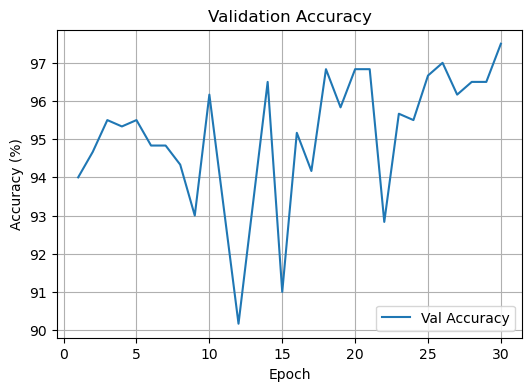

In [29]:
plt.figure(figsize=(6, 4))
sns.lineplot(data=metrics_df, x='Epoch', y='Val Accuracy', label='Val Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Training and Validation Loss

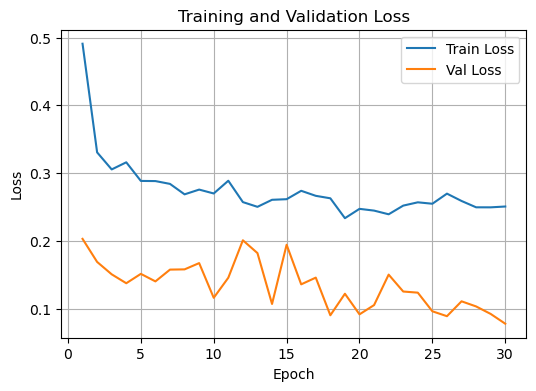

In [30]:
plt.figure(figsize=(6, 4))  # Adjust size here
sns.lineplot(data=metrics_df, x='Epoch', y='Train Loss', label='Train Loss')
sns.lineplot(data=metrics_df, x='Epoch', y='Val Loss', label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## Saving the model

In [31]:
torch.save(model.state_dict(), 'alexnet-model.pth')

print("Model saved successfully.")

Model saved successfully.
